In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import my_utils as myf
xr.set_options(keep_attrs=True)

In [2]:
mydir = './data/trefht_timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'trefht_timeseries' in f]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))
listds = []
for f in myfiles:
        ds = xr.open_dataset(f).sel(region='70-90N')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [3]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [4]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [5]:
ds = xr.concat([ds,lensmean, a60nudgemean],dim='names')

In [6]:
lineplotprop = myf.set_line_prop(ds.names.values)

In [7]:
da = myf.xr_reshape(ds.TREFHT,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
slope, intercept, r_value, p_value, std_err = myf.linregress(da.year, da.load(), dim='year')

annmean = mydata = ds.groupby('time.year').mean(dim='time').TREFHT
annmean_slope, _, _, annmean_p_value, _ = myf.linregress(da.year, annmean.load(), dim='year')

detrended = da - slope*da.year
detrendedannmean = annmean - annmean_slope*annmean.year

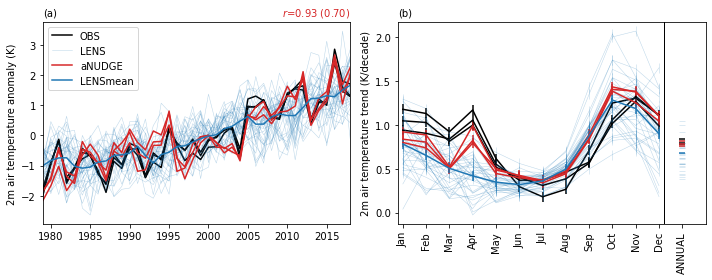

In [8]:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot(1,2,1)
for n, name in enumerate(ds.names.values):
    if 'NUDGEmean' not in name:
        mydata = ds.sel(names=name).groupby('time.year').mean(dim='time').TREFHT
        anom = mydata - mydata.mean(dim='year')
        anom.plot(ax = ax, **lineplotprop[name].to_dict())

        
pearson3, _ = myf.pearson(ds.groupby('time.year').mean(dim='time').TREFHT.sel(names='GISTEMPv4').load(), ds.groupby('time.year').mean(dim='time').TREFHT.sel(names='aNUDGEmean').load(),dim='year')
pearson3detrended, _ = myf.pearson(detrendedannmean.sel(names='GISTEMPv4').load(), detrendedannmean.sel(names='aNUDGEmean').load(),dim='year')

ax.set_title('')
ax.set_title('(a)',fontsize=10,loc='left')
ax.set_title('$r$={:0.2f} ({:1.2f})'.format(pearson3.values,pearson3detrended.values), fontsize=10, loc='right',c='tab:red')
ax.set_xlim([1979,2018])
ax.set_ylabel('2m air temperature anomaly (K)')
ax.set_xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=('upper left'))


ax = plt.subplot(1,2,2)
for n, name in enumerate(ds.names.values):
       if 'NUDGEmean' not in name:
        (10.*slope).sel(names=name).plot(ax = ax, **lineplotprop[name].to_dict())     
        
        for m in range(12):
            if p_value.sel(names=name).values[m]<.05:
                ax.scatter(m+1,(10.*slope).sel(names=name).values[m], **lineplotprop[name].to_dict(), marker='|',s=100)

        
        
        ax.scatter(13,10.*annmean_slope.sel(names=name),**lineplotprop[name].to_dict(), marker='_')
ax.set_title('')
ax.set_title('(b)', fontsize=10, loc='left')
ax.set_xlim([1,14])
ax.set_xticks(np.arange(1,14,1))
ax.set_xticklabels(myf.monthnames+['ANNUAL'], rotation='vertical')
ax.set_xlabel('')
ax.set_ylabel('2m air temperature trend (K/decade)')
ax.axvline(x=12.2,c='k',linewidth=1)
ax.set_xlim([.8,14])

plt.tight_layout()
fig.savefig('figs/tas.pdf', dpi=500, bbox_inches='tight')
plt.show(); plt.close()

In [9]:
annmean_p_value.values<0.05

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [10]:
ds  = ds.groupby('time.year').mean(dim='time')

In [11]:
mydict={}
for name in ['GISTEMPv4','LENSmean','aNUDGEmean']:
    mylist = []
    for period in [[0,None],[0,20],[20,None]]:
        
        trend, intercept, r_value, p_value, std_err =myf.linregress(ds.isel(year=slice(period[0],period[1])).year, 
                                                                    ds.isel(year=slice(period[0],period[1])).sel(names=name).TREFHT.load(), dim='year')
        
        entry = '{:.2f} \pm {:.2f} K/decade, p={:.0f} \%'.format(10.*trend.values,10.*std_err.values,100.*p_value.values)
        #entry = '{:.2f} $\pm$ {:.2f} K/decade'.format(10.*trend.values,10.*std_err.values)
        
        mylist.append(entry)
    mydict[name] = mylist

        

In [12]:
pd.DataFrame(mydict).transpose()

,0,1,2
GISTEMPv4,"0.80 \pm 0.07 K/decade, p=0 \%","0.50 \pm 0.18 K/decade, p=1 \%","1.12 \pm 0.20 K/decade, p=0 \%"
LENSmean,"0.68 \pm 0.03 K/decade, p=0 \%","0.32 \pm 0.07 K/decade, p=0 \%","0.86 \pm 0.05 K/decade, p=0 \%"
aNUDGEmean,"0.79 \pm 0.08 K/decade, p=0 \%","0.57 \pm 0.21 K/decade, p=1 \%","1.28 \pm 0.19 K/decade, p=0 \%"
